In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    auc
)

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

print("=== MODEL TRAINING & EVALUATION ===")

df = pd.read_csv("preprocessed_loan.csv")

X = df.drop("target", axis=1)
y = df["target"]

print("Dataset shape:", df.shape)
print("Target distribution:")
print(y.value_counts(normalize=True))

=== MODEL TRAINING & EVALUATION ===
Dataset shape: (1345310, 84)
Target distribution:
target
0    0.800374
1    0.199626
Name: proportion, dtype: float64


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

Train size: (1076248, 83)
Test size : (269062, 83)


## Baseline Model - Logistic Regression

In [3]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
lr_model = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    class_weight="balanced",  # penting untuk imbalance
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression trained.")

Logistic Regression trained.


In [5]:
# Probabilities
y_train_proba_lr = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba_lr  = lr_model.predict_proba(X_test_scaled)[:, 1]

# ROC-AUC
auc_train_lr = roc_auc_score(y_train, y_train_proba_lr)
auc_test_lr  = roc_auc_score(y_test, y_test_proba_lr)

print(f"LogReg AUC-ROC (Train): {auc_train_lr:.4f}")
print(f"LogReg AUC-ROC (Test) : {auc_test_lr:.4f}")

LogReg AUC-ROC (Train): 0.9921
LogReg AUC-ROC (Test) : 0.9923


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    215350
           1       0.90      0.96      0.93     53712

    accuracy                           0.97    269062
   macro avg       0.94      0.97      0.95    269062
weighted avg       0.97      0.97      0.97    269062



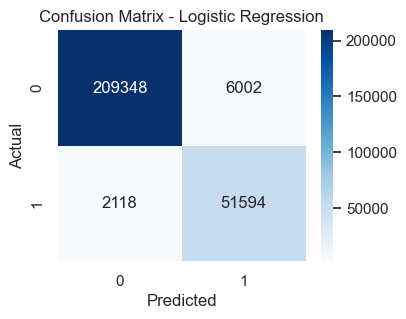

In [6]:
y_pred_lr = lr_model.predict(X_test_scaled)

print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(4,3))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [7]:
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_lr)
pr_auc_lr = auc(recall, precision)

print(f"LogReg PR-AUC: {pr_auc_lr:.4f}")

LogReg PR-AUC: 0.9833


## XGBoost

In [8]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
print("XGBoost trained.")

XGBoost trained.


In [9]:
y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]
y_test_proba_xgb  = xgb_model.predict_proba(X_test)[:, 1]

auc_train_xgb = roc_auc_score(y_train, y_train_proba_xgb)
auc_test_xgb  = roc_auc_score(y_test, y_test_proba_xgb)

print(f"XGB AUC-ROC (Train): {auc_train_xgb:.4f}")
print(f"XGB AUC-ROC (Test) : {auc_test_xgb:.4f}")

XGB AUC-ROC (Train): 0.9974
XGB AUC-ROC (Test) : 0.9973


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    215350
           1       0.99      0.94      0.96     53712

    accuracy                           0.99    269062
   macro avg       0.99      0.97      0.98    269062
weighted avg       0.99      0.99      0.99    269062



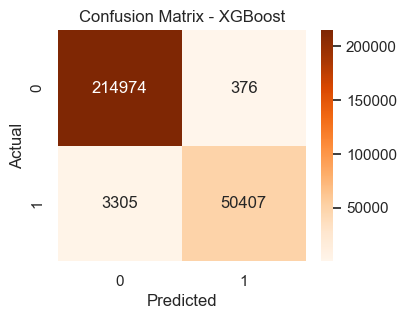

In [10]:
y_pred_xgb = xgb_model.predict(X_test)

print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(4,3))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_proba_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)

print(f"XGBoost PR-AUC: {pr_auc_xgb:.4f}")

XGBoost PR-AUC: 0.9928


## Summary

In [12]:
summary = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost"],
    "AUC-ROC (Train)": [auc_train_lr, auc_train_xgb],
    "AUC-ROC (Test)":  [auc_test_lr, auc_test_xgb],
    "PR-AUC":          [pr_auc_lr, pr_auc_xgb]
})

summary

,Model,AUC-ROC (Train),AUC-ROC (Test),PR-AUC
0,Logistic Regression,0.992062,0.992297,0.983266
1,XGBoost,0.997384,0.997265,0.992824
